# Process 'Student Ideal Role' Question Using a LLM

A generic version of the pipeline to be re-used for different types of questions.

Andrew Weng, 1/1/2025

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [1]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [2]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [3]:
question = dict()
question['tag'] = 'student_ideal_title'
question['categories'] = ['Academic Positions',
 'Research Scientists',
 'Battery Engineers',
 'Battery Research Scientists',
 'Cell Engineers',
 'Materials Scientists/Engineers',
 'Modeling / Computational Researchers',
 'Thermal Engineers',
 'Controls Engineers / BMS Engineers',
 'R&D Engineers',
 'Product Engineers',
 'Data Engineer',
 'Consultants',
 'Management Roles',
 'Venture Capital',
 'Calibrator',
 'Battery Recycling Researcher']
question['question'] = 'After you graduate, what would be your ideal job title?'
question['data'] = analyst.summarize_student_ideal()['ideal_job_title_list']

In [4]:
question['data']

['Assistant Professor',
 'Battery Engineer',
 'Battery R&D Engineer',
 'R&D researcher',
 'Research assistant',
 'Research Scientist',
 'Battery Engineer',
 'Product development scientist',
 'Venture Capital Principal',
 'Professor',
 'Battery Algorithm Engineer, Thermal Controls Engineer, BMS Engineer, Propulsion Controls Engineer',
 'Battery Researcher',
 'Calibrator',
 'R&D Engineer',
 'Cell engineer',
 'Battery material engineer',
 'Battery test Engineer',
 'Product Engineer',
 'Senior R&D Engineer',
 'Research associate or research scientist',
 'Scientist',
 'Battery research scientist',
 'Scientist in battery research',
 'CTO',
 'Cell engineer',
 'Data Engineer',
 'Battery Modeling Engineer',
 'Electrification/thermal engineer',
 'Research scientist',
 'Scientist',
 'Battery degradation analysis',
 'Battery R&D Engineer',
 'Scientist',
 'Battery Scientist',
 'Researcher in Battery Lab',
 'Senior researcher',
 'material scientist',
 'Battery Engineer',
 'Battery Modeling Engineer'

# Pre-process the user response

Interpret the delimiters

In [5]:
# If only a single keyword is expected then skip this step

keyword_list = question['data']

# Define categories

In [8]:
if question['categories'] == []:

    categories = llm.define_categories(question['question'],
                                       keyword_list,
                                       num_categories=50)

    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])

else:
    category_list = question['categories']

pprint(category_list)

['Academic Positions',
 'Research Scientists',
 'Battery Engineers',
 'Battery Research Scientists',
 'Cell Engineers',
 'Materials Scientists/Engineers',
 'Modeling / Computational Researchers',
 'Thermal Engineers',
 'Controls Engineers / BMS Engineers',
 'R&D Engineers',
 'Product Engineers',
 'Data Engineer',
 'Consultants',
 'Management Roles',
 'Venture Capital',
 'Calibrator',
 'Battery Recycling Researcher']


# Assign categories

Process one keyword at a time!

In [9]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Processing response: '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list, keyword,
                                            model='gpt-4o-mini')
    except: # JSON output fails
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'Assistant Professor' (1 of 78)...
Processing response: 'Battery Engineer' (2 of 78)...
Processing response: 'Battery R&D Engineer' (3 of 78)...
Processing response: 'R&D researcher' (4 of 78)...
Processing response: 'Research assistant' (5 of 78)...
Processing response: 'Research Scientist' (6 of 78)...
Processing response: 'Battery Engineer' (7 of 78)...
Processing response: 'Product development scientist' (8 of 78)...
Processing response: 'Venture Capital Principal' (9 of 78)...
Processing response: 'Professor' (10 of 78)...
Processing response: 'Battery Algorithm Engineer, Thermal Controls Engineer, BMS Engineer, Propulsion Controls Engineer' (11 of 78)...
Processing response: 'Battery Researcher' (12 of 78)...
Processing response: 'Calibrator' (13 of 78)...
Processing response: 'R&D Engineer' (14 of 78)...
Processing response: 'Cell engineer' (15 of 78)...
Processing response: 'Battery material engineer' (16 of 78)...
Processing response: 'Battery test Enginee

In [10]:
print(len(other_list))

0


In [11]:
other_list

[]

In [12]:
print(len(fail_list))

0


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [14]:

collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Academic Positions': 6,
             'Battery Engineers': 5,
             'R&D Engineers': 11,
             'Research Scientists': 18,
             'Product Engineers': 3,
             'Venture Capital': 1,
             'Controls Engineers / BMS Engineers': 2,
             'Battery Research Scientists': 12,
             'Calibrator': 1,
             'Cell Engineers': 4,
             'Materials Scientists/Engineers': 4,
             'Management Roles': 2,
             'Data Engineer': 1,
             'Modeling / Computational Researchers': 5,
             'Thermal Engineers': 1,
             'Consultants': 1,
             'Battery Recycling Researcher': 1,
             '_tot_': 78})

In [15]:
collection

defaultdict(list,
            {'Academic Positions': ['Assistant Professor',
              'Professor',
              'Assistant Professor',
              'University Professor',
              'Assistant Professor',
              'after geaduating i want to apply for a strong position in Ph.D'],
             'Battery Engineers': ['Battery Engineer',
              'Battery Engineer',
              'Battery test Engineer',
              'Battery Engineer',
              'Sr. Battery Engineer (BMS or other)'],
             'R&D Engineers': ['Battery R&D Engineer',
              'R&D researcher',
              'R&D Engineer',
              'Senior R&D Engineer',
              'Battery R&D Engineer',
              'Entry level engineer',
              'Battery R&D',
              'R&D engineer',
              'early-stage engineer',
              'Research and development engineer',
              'R&D role'],
             'Research Scientists': ['Research assistant',
              'Research

# Visualize the results

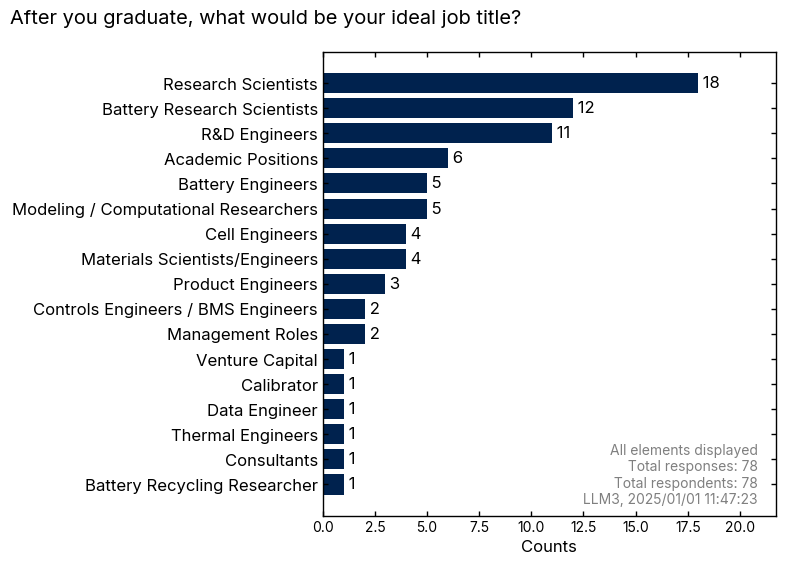

In [16]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_{time.strftime("%Y%m%d_%H%M%S")}.png'
)